In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from EnderClassifierModified import EnderClassifier as ECM
from EnderClassifierBoundedFast import EnderClassifier as ECBF
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import OrdinalEncoder

In [18]:
def run_test(model, name, X_train, y_train, X_test, y_test):
    if len(np.unique(y_train)) != 2 or len(np.unique(y_test)) != 2:
        print(f"Skipping {name} as it is not a binary classification problem.")
        return
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.array(y_pred)
    if y_pred.ndim > 1:
        y_pred = np.array([np.argmax(pred) for pred in y_pred])
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(name)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.5f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.5f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.5f}")
    print("Classification Report - Test:")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    labels = ['Class 0', 'Class 1']
    print("Confusion Matrix:")
    print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
    print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
    print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.4f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [3]:
def find_best_n(ender_version, use_gradient, X_train, y_train, X_test, y_test, min_n=0, max_n=31):
    best_acc = 0
    best_n = 0
    best_acc_auc = 0
    best_acc_f1 = 0
    best_auc = 0
    best_n_auc = 0
    best_auc_acc = 0
    best_auc_f1 = 0
    best_f1 = 0
    best_n_f1 = 0
    best_f1_auc = 0
    best_f1_acc = 0
    for n_rules in range(min_n, max_n):
        ender = ender_version(verbose=False, n_rules=n_rules, use_gradient=use_gradient)
        ender.fit(X_train, y_train)
        y_pred = ender.predict(X_test)
        y_pred = np.array(y_pred)
        y_pred = np.argmax(y_pred, axis=1) if y_pred.ndim > 1 else y_pred
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        y_proba = ender.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        if acc > best_acc + 1e-6:
            best_acc = acc
            best_n = n_rules
            best_acc_auc = auc
            best_acc_f1 = f1
        if auc > best_auc + 1e-6:
            best_auc = auc
            best_auc_acc = acc
            best_n_auc = n_rules
            best_auc_f1 = f1
        if f1 > best_f1 + 1e-6:
            best_f1 = f1
            best_n_f1 = n_rules
            best_f1_auc = auc
            best_f1_acc = acc
    print(f"Best accuracy: {best_acc:.4f} with n_rules: {best_n}, AUC: {best_acc_auc:.4f}, F1: {best_acc_f1:.4f}")
    print(f"Best AUC: {best_auc:.4f} with n_rules: {best_n_auc}, Accuracy: {best_auc_acc:.4f}, F1: {best_auc_f1:.4f}")
    print(f"Best F1: {best_f1:.4f} with n_rules: {best_n_f1}, AUC: {best_f1_auc:.4f}, Accuracy: {best_f1_acc:.4f}")

In [4]:
from ucimlrepo import fetch_ucirepo 
  
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)
heart_disease = fetch_ucirepo(id=45)
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
liver_disorders = fetch_ucirepo(id=60) 
ilpd_indian_liver_patient_dataset = fetch_ucirepo(id=225)

c:\Users\iwama\Desktop\Osobiste\MSc\mscenv\Lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [5]:
diabetes_X = diabetes_130_us_hospitals_for_years_1999_2008.data.features.copy()
diabetes_y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets.copy()

heart_disease_X = heart_disease.data.features.copy()
heart_disease_y = heart_disease.data.targets.copy()

breast_cancer_X = breast_cancer_wisconsin_diagnostic.data.features.copy()
breast_cancer_y = breast_cancer_wisconsin_diagnostic.data.targets.copy()

liver_disorders_X = liver_disorders.data.features.copy()
liver_disorders_y = liver_disorders.data.targets.copy()

ilpd_X = ilpd_indian_liver_patient_dataset.data.features.copy()
ilpd_y = ilpd_indian_liver_patient_dataset.data.targets.copy()

In [6]:
print("Diabetes dataset shape:", diabetes_X.shape)
print("Heart Disease dataset shape:", heart_disease_X.shape)
print("Breast Cancer dataset shape:", breast_cancer_X.shape)
print("Liver Disorders dataset shape:", liver_disorders_X.shape)
print("ILPD dataset shape:", ilpd_X.shape)

Diabetes dataset shape: (101766, 47)
Heart Disease dataset shape: (303, 13)
Breast Cancer dataset shape: (569, 30)
Liver Disorders dataset shape: (345, 5)
ILPD dataset shape: (583, 10)


In [7]:
print("Diabetes dataset missing values:", diabetes_X.isnull().sum().sum())
print("Heart Disease dataset missing values:", heart_disease_X.isnull().sum().sum())
print("Breast Cancer dataset missing values:", breast_cancer_X.isnull().sum().sum())
print("Liver Disorders dataset missing values:", liver_disorders_X.isnull().sum().sum())
print("ILPD dataset missing values:", ilpd_X.isnull().sum().sum())

Diabetes dataset missing values: 374017
Heart Disease dataset missing values: 6
Breast Cancer dataset missing values: 0
Liver Disorders dataset missing values: 0
ILPD dataset missing values: 4


In [8]:
# print the number of classes in each dataset
print("Diabetes dataset classes:", np.unique(diabetes_y))
print("Heart Disease dataset classes:", np.unique(heart_disease_y))
print("Breast Cancer dataset classes:", np.unique(breast_cancer_y))
print("Liver Disorders dataset classes:", np.unique(liver_disorders_y))
print("ILPD dataset classes:", np.unique(ilpd_y))

Diabetes dataset classes: ['<30' '>30' 'NO']
Heart Disease dataset classes: [0 1 2 3 4]
Breast Cancer dataset classes: ['B' 'M']
Liver Disorders dataset classes: [ 0.   0.5  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  12.  15.
 16.  20. ]
ILPD dataset classes: [1 2]


### Diabetes dataset
1. Deal with missing values

In [9]:
missing_values = diabetes_X.isnull().sum()
print(missing_values[missing_values > 0])

race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
max_glu_serum        96420
A1Cresult            84748
dtype: int64


In [10]:
diabetes_X.race.value_counts()

race
Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64

In [11]:
diabetes_categorical_cols = diabetes_X.select_dtypes(include=['object']).columns
diabetes_encoders = {}
for col in diabetes_categorical_cols:
    le = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, encoded_missing_value=-1)
    diabetes_X[col] = le.fit_transform(diabetes_X[col].to_frame())
    diabetes_encoders[col] = le

In [12]:
# count missing values
missing_values = diabetes_X.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [13]:
diabetes_X.race.value_counts()

race
 2.0    76099
 0.0    19210
-1.0     2273
 3.0     2037
 4.0     1506
 1.0      641
Name: count, dtype: int64

2. Change the target to binary classification: 0 if not readmitted, 1 if readmitted after some time

In [14]:
diabetes_y.readmitted.value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

In [15]:
# change diabetes_y to a binary classification problem
# "NO" -> 0, "<30" and ">30" -> 1
diabetes_y = diabetes_y.replace({"NO": 0, "<30": 1, ">30": 1})
diabetes_y.rename(columns={"readmitted": "target"}, inplace=True)
diabetes_y = diabetes_y.target.to_numpy()

C:\Users\iwama\AppData\Local\Temp\ipykernel_2656\2988319950.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetes_y = diabetes_y.replace({"NO": 0, "<30": 1, ">30": 1})


In [16]:
# Count the values of diabetes_y which is a np.array
unique, counts = np.unique(diabetes_y, return_counts=True)
value_counts = dict(zip(unique, counts))
value_counts

{np.int64(0): np.int64(54864), np.int64(1): np.int64(46902)}

3. Optimise hyperparameters using holdout and 5-fold Cross Validation

In [17]:
X_trainval, X_test, y_trainval, y_test = train_test_split(diabetes_X, diabetes_y, test_size=0.25, random_state=42, stratify=diabetes_y)

print(f"Train/Val size: {len(y_trainval)}, Test size: {len(y_test)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")

Train/Val size: 76324, Test size: 25442
Class distribution in test set: [13716 11726]


### XGBoost baseline

In [19]:
param_grid_xgb = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'scale_pos_weight': [4, 5, 6]  # based on imbalance ratio
}
grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search_xgb.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search_xgb.best_params_)
print("Best cross-val F1:", grid_search_xgb.best_score_)

best_model = grid_search_xgb.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

Best hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'scale_pos_weight': 4, 'subsample': 0.6}
Best cross-val F1: 0.6541087469487316

Test set evaluation:
              precision    recall  f1-score   support

           0     0.8756    0.1411    0.2431     13716
           1     0.4929    0.9765    0.6551     11726

    accuracy                         0.5262     25442
   macro avg     0.6843    0.5588    0.4491     25442
weighted avg     0.6992    0.5262    0.4330     25442

Confusion Matrix:
                    Class 0             Class 1             
Class 0             1936                11780                 # True Negative (TN), False Positive (FP)
Class 1             275                 11451                 # False Negative (FN), True Positive (TP)


In [25]:
# get the indexes of the top 20 highest values from the mean_test_score
top_20_indices = sorted(range(len(grid_search_xgb.cv_results_['mean_test_score'])), key=lambda i: grid_search_xgb.cv_results_['mean_test_score'][i], reverse=True)[:20]
print(top_20_indices)
# Get the parameters for the top 20
top_20_params = [grid_search_xgb.cv_results_['params'][i] for i in top_20_indices]
print(top_20_params)
print("=====================================================")
# print the scores alongside the parameters for the top 20
for i in top_20_indices:
    print(f"Score: {grid_search_xgb.cv_results_['mean_test_score'][i]}, Params: {grid_search_xgb.cv_results_['params'][i]}")
    print("=====================================================")

[5823, 6552, 5095, 3582, 5094, 5797, 6499, 5068, 5067, 3609, 5824, 6498, 2853, 5040, 5796, 4311, 2854, 6553, 4366, 4365]
[{'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'scale_pos_weight': 4, 'subsample': 0.6}, {'colsample_bytree': 1.0, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'scale_pos_weight': 4, 'subsample': 0.6}, {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'scale_pos_weight': 4, 'subsample': 0.8}, {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': 4, 'subsample': 0.6}, {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'scale_pos_weight': 4, 'subsample': 0.6}, {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 

XGBoost Baseline (heart disease)
Accuracy: 0.65089
ROC AUC: 0.70730
F1 Score: 0.60041
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.6618    0.7208    0.6900     13716
           1     0.6354    0.5691    0.6004     11726

    accuracy                         0.6509     25442
   macro avg     0.6486    0.6450    0.6452     25442
weighted avg     0.6496    0.6509    0.6487     25442

Confusion Matrix:
                    Class 0             Class 1             
Class 0             9887                3829                  # True Negative (TN), False Positive (FP)
Class 1             5053                6673                  # False Negative (FN), True Positive (TP)


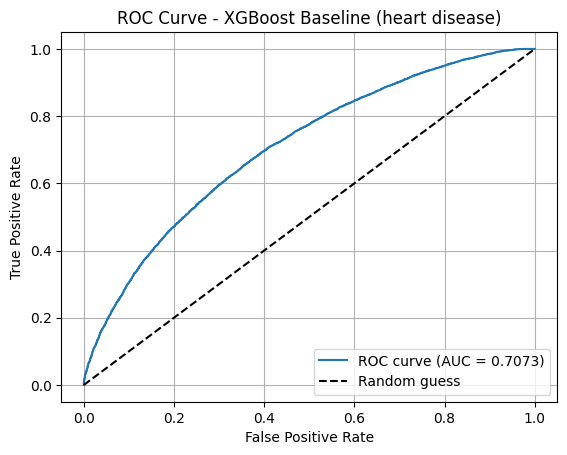

In [30]:
xgb_default_model = xgb.XGBClassifier()
run_test(xgb_default_model, "XGBoost Baseline (heart disease)", X_trainval, y_trainval, X_test, y_test)

### Ender Classifier Modified

In [18]:
param_grid = {
    'n_rules': [5,7,10,15,20],
    'use_gradient': [True, False],
    'nu': [0.9, 0.95, 0.99, 1.0],
    'sampling': [0.4, 0.6, 0.8, 0.9, 1.0],
    'verbose': [False]
}

grid_search_m = GridSearchCV(
    estimator=ECM(),
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search_m.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search_m.best_params_)
print("Best cross-val F1:", grid_search_m.best_score_)

best_model = grid_search_m.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

Best hyperparameters: {'n_rules': 15, 'nu': 0.99, 'sampling': 0.4, 'use_gradient': True, 'verbose': False}
Best cross-val F1: 0.5630090117568484

Test set evaluation:
              precision    recall  f1-score   support

           0     0.6301    0.7601    0.6890     13716
           1     0.6301    0.4780    0.5436     11726

    accuracy                         0.6301     25442
   macro avg     0.6301    0.6191    0.6163     25442
weighted avg     0.6301    0.6301    0.6220     25442

Confusion Matrix:
                    Class 0             Class 1             
Class 0             10426               3290                  # True Negative (TN), False Positive (FP)
Class 1             6121                5605                  # False Negative (FN), True Positive (TP)


In [20]:
# get the indexes of the top 20 highest values from the mean_test_score
top_20_indices = sorted(range(len(grid_search_m.cv_results_['mean_test_score'])), key=lambda i: grid_search_m.cv_results_['mean_test_score'][i], reverse=True)[:20]
print(top_20_indices)
# Get the parameters for the top 20
top_20_params = [grid_search_m.cv_results_['params'][i] for i in top_20_indices]
print(top_20_params)
print("=====================================================")
# print the scores alongside the parameters for the top 20
for i in top_20_indices:
    print(f"Score: {grid_search_m.cv_results_['mean_test_score'][i]}, Params: {grid_search_m.cv_results_['params'][i]}")
    print("=====================================================")

# save the top 20 parameters into a file in json format
import json
with open('top_20_params_diabetes_ecm.json', 'w') as f:
    json.dump(top_20_params, f, indent=4)
# save the scores in a file as well
with open('top_20_scores_diabetes_ecm.json', 'w') as f:
    json.dump([grid_search_m.cv_results_['mean_test_score'][i] for i in top_20_indices], f, indent=4)

[140, 196, 194, 186, 184, 122, 174, 198, 178, 188, 152, 168, 164, 120, 176, 132, 142, 190, 130, 150]
[{'n_rules': 15, 'nu': 0.99, 'sampling': 0.4, 'use_gradient': True, 'verbose': False}, {'n_rules': 20, 'nu': 1.0, 'sampling': 0.9, 'use_gradient': True, 'verbose': False}, {'n_rules': 20, 'nu': 1.0, 'sampling': 0.8, 'use_gradient': True, 'verbose': False}, {'n_rules': 20, 'nu': 0.99, 'sampling': 0.9, 'use_gradient': True, 'verbose': False}, {'n_rules': 20, 'nu': 0.99, 'sampling': 0.8, 'use_gradient': True, 'verbose': False}, {'n_rules': 15, 'nu': 0.9, 'sampling': 0.6, 'use_gradient': True, 'verbose': False}, {'n_rules': 20, 'nu': 0.95, 'sampling': 0.8, 'use_gradient': True, 'verbose': False}, {'n_rules': 20, 'nu': 1.0, 'sampling': 1.0, 'use_gradient': True, 'verbose': False}, {'n_rules': 20, 'nu': 0.95, 'sampling': 1.0, 'use_gradient': True, 'verbose': False}, {'n_rules': 20, 'nu': 0.99, 'sampling': 1.0, 'use_gradient': True, 'verbose': False}, {'n_rules': 15, 'nu': 1.0, 'sampling': 0.6

In [21]:
param_grid = {
    'n_rules': [i for i in range(20, 31, 2)],
    'use_gradient': [True],
    'nu': [0.99, 1.0],
    'sampling': [0.8, 0.9, 1.0],
    'verbose': [False]
}

grid_search_m_2 = GridSearchCV(
    estimator=ECM(),
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search_m_2.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search_m_2.best_params_)
print("Best cross-val F1:", grid_search_m_2.best_score_)

best_model = grid_search_m_2.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

Best hyperparameters: {'n_rules': 30, 'nu': 1.0, 'sampling': 0.9, 'use_gradient': True, 'verbose': False}
Best cross-val F1: 0.566224389174482

Test set evaluation:
              precision    recall  f1-score   support

           0     0.6407    0.7448    0.6888     13716
           1     0.6314    0.5114    0.5651     11726

    accuracy                         0.6372     25442
   macro avg     0.6360    0.6281    0.6270     25442
weighted avg     0.6364    0.6372    0.6318     25442

Confusion Matrix:
                    Class 0             Class 1             
Class 0             10215               3501                  # True Negative (TN), False Positive (FP)
Class 1             5729                5997                  # False Negative (FN), True Positive (TP)


In [22]:
# get the indexes of the top 20 highest values from the mean_test_score
top_20_indices = sorted(range(len(grid_search_m_2.cv_results_['mean_test_score'])), key=lambda i: grid_search_m_2.cv_results_['mean_test_score'][i], reverse=True)[:20]
print(top_20_indices)
# Get the parameters for the top 20
top_20_params = [grid_search_m_2.cv_results_['params'][i] for i in top_20_indices]
print(top_20_params)
print("=====================================================")
# print the scores alongside the parameters for the top 20
for i in top_20_indices:
    print(f"Score: {grid_search_m_2.cv_results_['mean_test_score'][i]}, Params: {grid_search_m_2.cv_results_['params'][i]}")
    print("=====================================================")


[34, 35, 30, 13, 12, 28, 32, 33, 25, 23, 24, 19, 29, 9, 26, 20, 11, 27, 21, 31]
[{'n_rules': 30, 'nu': 1.0, 'sampling': 0.9, 'use_gradient': True, 'verbose': False}, {'n_rules': 30, 'nu': 1.0, 'sampling': 1.0, 'use_gradient': True, 'verbose': False}, {'n_rules': 30, 'nu': 0.99, 'sampling': 0.8, 'use_gradient': True, 'verbose': False}, {'n_rules': 24, 'nu': 0.99, 'sampling': 0.9, 'use_gradient': True, 'verbose': False}, {'n_rules': 24, 'nu': 0.99, 'sampling': 0.8, 'use_gradient': True, 'verbose': False}, {'n_rules': 28, 'nu': 1.0, 'sampling': 0.9, 'use_gradient': True, 'verbose': False}, {'n_rules': 30, 'nu': 0.99, 'sampling': 1.0, 'use_gradient': True, 'verbose': False}, {'n_rules': 30, 'nu': 1.0, 'sampling': 0.8, 'use_gradient': True, 'verbose': False}, {'n_rules': 28, 'nu': 0.99, 'sampling': 0.9, 'use_gradient': True, 'verbose': False}, {'n_rules': 26, 'nu': 1.0, 'sampling': 1.0, 'use_gradient': True, 'verbose': False}, {'n_rules': 28, 'nu': 0.99, 'sampling': 0.8, 'use_gradient': Tru

In [23]:
param_grid = {
    'n_rules': [i for i in range(30, 41, 2)],
    'use_gradient': [True],
    'nu': [1.0],
    'sampling': [1.0],
    'verbose': [False]
}

grid_search_m_3 = GridSearchCV(
    estimator=ECM(),
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search_m_3.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search_m_3.best_params_)
print("Best cross-val F1:", grid_search_m_3.best_score_)

best_model = grid_search_m_3.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

Best hyperparameters: {'n_rules': 40, 'nu': 1.0, 'sampling': 1.0, 'use_gradient': True, 'verbose': False}
Best cross-val F1: 0.5731698335615523

Test set evaluation:
              precision    recall  f1-score   support

           0     0.6431    0.7381    0.6873     13716
           1     0.6297    0.5208    0.5701     11726

    accuracy                         0.6380     25442
   macro avg     0.6364    0.6295    0.6287     25442
weighted avg     0.6369    0.6380    0.6333     25442

Confusion Matrix:
                    Class 0             Class 1             
Class 0             10124               3592                  # True Negative (TN), False Positive (FP)
Class 1             5619                6107                  # False Negative (FN), True Positive (TP)


Best ECM Model (heart disease)
Accuracy: 0.63914
ROC AUC: 0.69101
F1 Score: 0.57681
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.6465    0.7294    0.6855     13716
           1     0.6276    0.5336    0.5768     11726

    accuracy                         0.6391     25442
   macro avg     0.6371    0.6315    0.6311     25442
weighted avg     0.6378    0.6391    0.6354     25442

Confusion Matrix:
                    Class 0             Class 1             
Class 0             10004               3712                  # True Negative (TN), False Positive (FP)
Class 1             5469                6257                  # False Negative (FN), True Positive (TP)


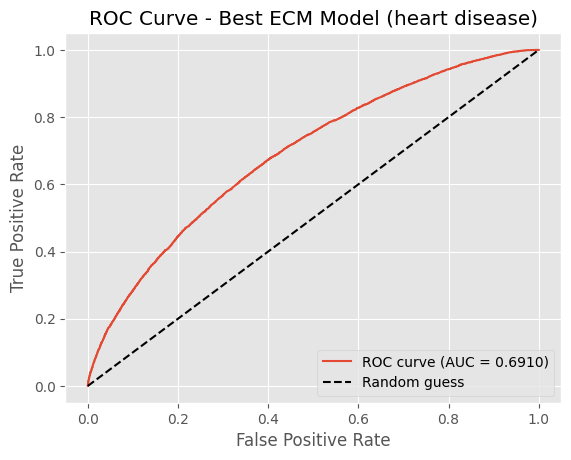

In [31]:
best_ecm_model = ECM(n_rules=60, use_gradient=True, nu=1.0, sampling=1.0, verbose=False)
run_test(best_ecm_model, "Best ECM Model (heart disease)", X_trainval, y_trainval, X_test, y_test)

Best ECM Model (120 rules) (heart disease)
Accuracy: 0.64456
ROC AUC: 0.69838
F1 Score: 0.58927
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.6542    0.7227    0.6867     13716
           1     0.6304    0.5532    0.5893     11726

    accuracy                         0.6446     25442
   macro avg     0.6423    0.6379    0.6380     25442
weighted avg     0.6432    0.6446    0.6418     25442

Confusion Matrix:
                    Class 0             Class 1             
Class 0             9912                3804                  # True Negative (TN), False Positive (FP)
Class 1             5239                6487                  # False Negative (FN), True Positive (TP)


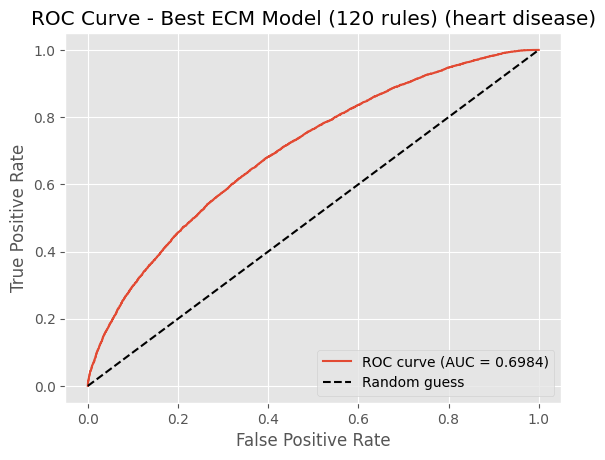

In [32]:
best_ecm_model = ECM(n_rules=120, use_gradient=True, nu=1.0, sampling=1.0, verbose=False)
run_test(best_ecm_model, "Best ECM Model (120 rules) (heart disease)", X_trainval, y_trainval, X_test, y_test)

### Bounded ENDER Classifier

In [ ]:
param_grid = {
    'n_rules': [i for i in range(35, 61, 5)],
    'use_gradient': [True, False],
    'nu': [0.8, 0.9, 0.95, 0.99, 1.0],
    'sampling': [0.8, 0.9, 1.0],
    'verbose': [False],
    'max_clusters': [i for i in range(1, 6)],
    'lambda_reg': [0.0, 0.1, 0.25, 0.5],
    'random_state': [42]
}

grid_search_bf = GridSearchCV(
    estimator=ECBF(),
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search_bf.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search_bf.best_params_)
print("Best cross-val F1:", grid_search_bf.best_score_)

best_model = grid_search_bf.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

ECBF Model
Accuracy: 0.6312
ROC AUC: 0.6668
F1 Score: 0.5405
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.6294    0.7683    0.6919     13716
           1     0.6346    0.4707    0.5405     11726

    accuracy                         0.6312     25442
   macro avg     0.6320    0.6195    0.6162     25442
weighted avg     0.6318    0.6312    0.6222     25442

Confusion Matrix:
                    Class 0             Class 1             
Class 0             10538               3178                  # True Negative (TN), False Positive (FP)
Class 1             6206                5520                  # False Negative (FN), True Positive (TP)


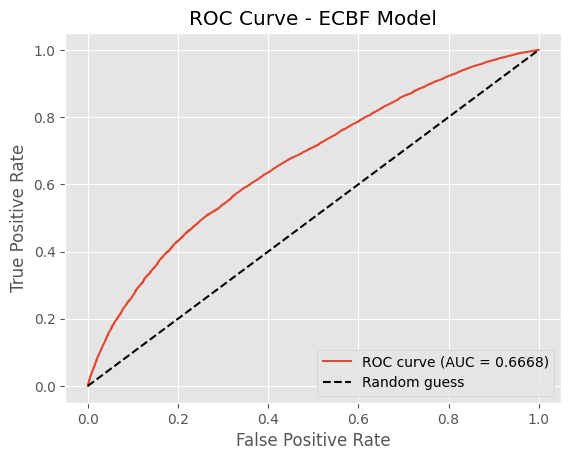

In [20]:
run_test(ECBF(n_rules=35, use_gradient=True, nu=0.99, sampling=0.8, verbose=False, max_clusters=3, lambda_reg=0.0), "ECBF Model", X_trainval, y_trainval, X_test, y_test)

ECBF Model
Accuracy: 0.6294
ROC AUC: 0.6768
F1 Score: 0.5476
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.6313    0.7512    0.6861     13716
           1     0.6259    0.4868    0.5476     11726

    accuracy                         0.6294     25442
   macro avg     0.6286    0.6190    0.6168     25442
weighted avg     0.6288    0.6294    0.6223     25442

Confusion Matrix:
                    Class 0             Class 1             
Class 0             10304               3412                  # True Negative (TN), False Positive (FP)
Class 1             6018                5708                  # False Negative (FN), True Positive (TP)


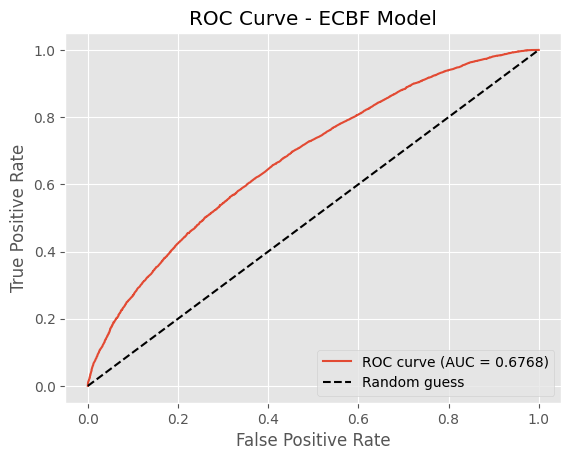

In [22]:
run_test(ECBF(n_rules=35, use_gradient=False, nu=0.99, sampling=0.8, verbose=False, max_clusters=3, lambda_reg=0.0), "ECBF Model", X_trainval, y_trainval, X_test, y_test)

ECBF Model
Accuracy: 0.6304
ROC AUC: 0.6781
F1 Score: 0.5506
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.6327    0.7493    0.6861     13716
           1     0.6262    0.4913    0.5506     11726

    accuracy                         0.6304     25442
   macro avg     0.6295    0.6203    0.6184     25442
weighted avg     0.6297    0.6304    0.6236     25442

Confusion Matrix:
                    Class 0             Class 1             
Class 0             10277               3439                  # True Negative (TN), False Positive (FP)
Class 1             5965                5761                  # False Negative (FN), True Positive (TP)


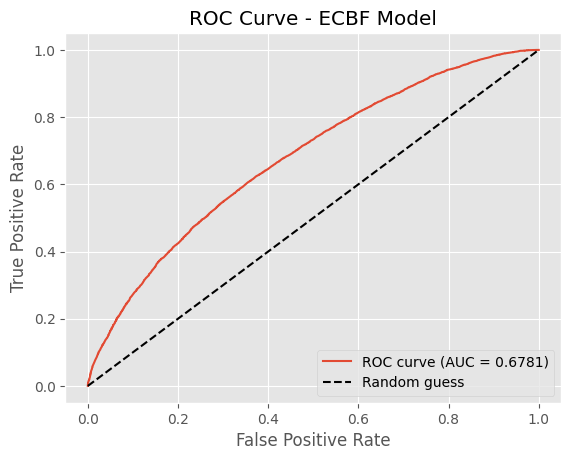

In [23]:
run_test(ECBF(n_rules=35, use_gradient=False, nu=1.0, sampling=1.0, verbose=False, max_clusters=3, lambda_reg=0.0), "ECBF Model", X_trainval, y_trainval, X_test, y_test)

ECBF Model
Accuracy: 0.6304
ROC AUC: 0.6781
F1 Score: 0.5506
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.6327    0.7493    0.6861     13716
           1     0.6262    0.4913    0.5506     11726

    accuracy                         0.6304     25442
   macro avg     0.6295    0.6203    0.6184     25442
weighted avg     0.6297    0.6304    0.6236     25442

Confusion Matrix:
                    Class 0             Class 1             
Class 0             10277               3439                  # True Negative (TN), False Positive (FP)
Class 1             5965                5761                  # False Negative (FN), True Positive (TP)


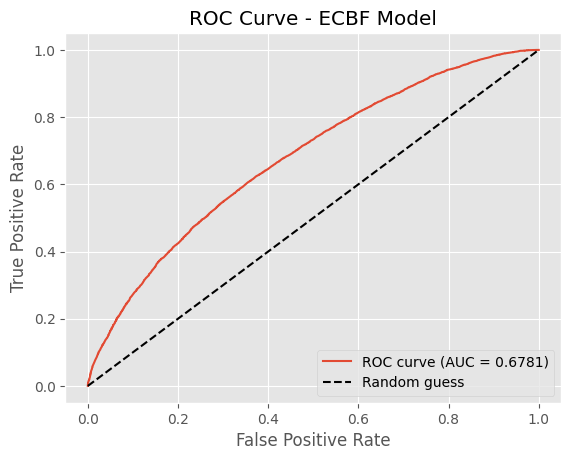

In [25]:
run_test(ECBF(n_rules=35, use_gradient=False, nu=1.0, sampling=1.0, verbose=False, max_clusters=2, lambda_reg=0.0), "ECBF Model", X_trainval, y_trainval, X_test, y_test)

ECBF Model
Accuracy: 0.6348
ROC AUC: 0.6812
F1 Score: 0.5560
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.6362    0.7534    0.6899     13716
           1     0.6323    0.4962    0.5560     11726

    accuracy                         0.6348     25442
   macro avg     0.6343    0.6248    0.6229     25442
weighted avg     0.6344    0.6348    0.6282     25442

Confusion Matrix:
                    Class 0             Class 1             
Class 0             10333               3383                  # True Negative (TN), False Positive (FP)
Class 1             5908                5818                  # False Negative (FN), True Positive (TP)


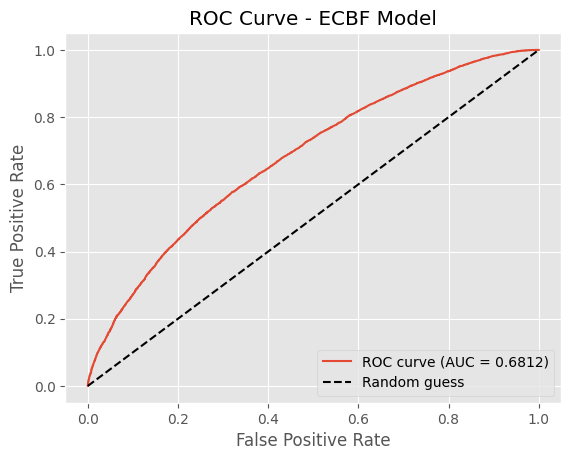

In [ ]:
run_test(ECBF(n_rules=50, use_gradient=False, nu=1.0, sampling=1.0, verbose=False, max_clusters=2, lambda_reg=0.0), "ECBF Model", X_trainval, y_trainval, X_test, y_test)

ECBF Model (diabetes)
Accuracy: 0.63497
ROC AUC: 0.68367
F1 Score: 0.55799
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.6371    0.7504    0.6891     13716
           1     0.6313    0.4999    0.5580     11726

    accuracy                         0.6350     25442
   macro avg     0.6342    0.6252    0.6236     25442
weighted avg     0.6344    0.6350    0.6287     25442

Confusion Matrix:
                    Class 0             Class 1             
Class 0             10293               3423                  # True Negative (TN), False Positive (FP)
Class 1             5864                5862                  # False Negative (FN), True Positive (TP)


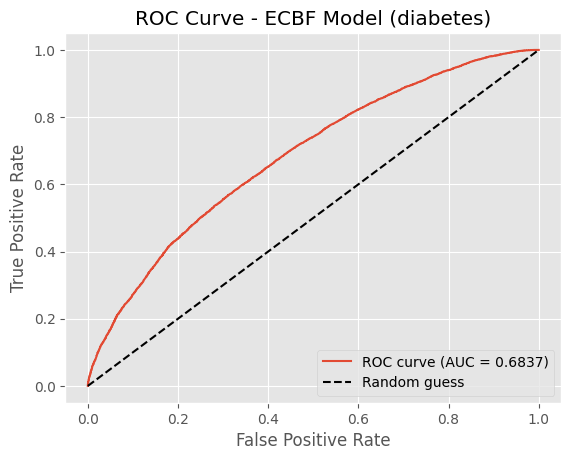

In [33]:
run_test(ECBF(n_rules=60, use_gradient=False, nu=1.0, sampling=1.0, verbose=False, max_clusters=2, lambda_reg=0.0), "ECBF Model (diabetes)", X_trainval, y_trainval, X_test, y_test)

ECBF Model (120 rules) (diabetes)
Accuracy: 0.64028
ROC AUC: 0.68930
F1 Score: 0.56720
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.6424    0.7504    0.6922     13716
           1     0.6366    0.5114    0.5672     11726

    accuracy                         0.6403     25442
   macro avg     0.6395    0.6309    0.6297     25442
weighted avg     0.6398    0.6403    0.6346     25442

Confusion Matrix:
                    Class 0             Class 1             
Class 0             10293               3423                  # True Negative (TN), False Positive (FP)
Class 1             5729                5997                  # False Negative (FN), True Positive (TP)


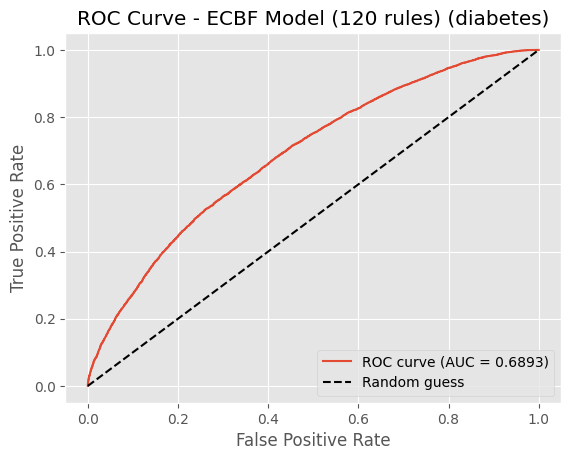

In [34]:
run_test(ECBF(n_rules=120, use_gradient=False, nu=1.0, sampling=1.0, verbose=False, max_clusters=2, lambda_reg=0.0), "ECBF Model (120 rules) (diabetes)", X_trainval, y_trainval, X_test, y_test)

## Classification on Heart Disease:

In [35]:
missing_values = heart_disease_X.isnull().sum()
print("Missing:\n", missing_values[missing_values > 0], "\nSamples: ", len(heart_disease_X), sep="")

Missing:
ca      4
thal    2
dtype: int64
Samples: 303


In [36]:
heart_disease_X = heart_disease_X.dropna()
heart_disease_y = heart_disease_y.loc[heart_disease_X.index]
print("After removing missing values, samples:", len(heart_disease_X))

After removing missing values, samples: 297


In [37]:
heart_disease_y['num'].value_counts()

num
0    160
1     54
2     35
3     35
4     13
Name: count, dtype: int64

In [38]:
# set the values of heart_disease_y.num to 0 if 0, else 1
heart_disease_y['num'] = heart_disease_y['num'].apply(lambda x: 0 if x == 0 else 1)
heart_disease_y['num'].value_counts()
heart_disease_y = heart_disease_y['num'].to_numpy()

In [39]:
X_trainval, X_test, y_trainval, y_test = train_test_split(heart_disease_X, heart_disease_y, test_size=0.25, random_state=42, stratify=heart_disease_y)

print(f"Train/Val size: {len(y_trainval)}, Test size: {len(y_test)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")

Train/Val size: 222, Test size: 75
Class distribution in test set: [40 35]


### XGBoost baseline

In [79]:
param_grid_xgb = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}
grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search_xgb.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search_xgb.best_params_)
print("Best cross-val F1:", grid_search_xgb.best_score_)

best_model = grid_search_xgb.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

Best hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.6}
Best cross-val F1: 0.8353719878751971

Test set evaluation:
              precision    recall  f1-score   support

           0     0.8537    0.8750    0.8642        40
           1     0.8529    0.8286    0.8406        35

    accuracy                         0.8533        75
   macro avg     0.8533    0.8518    0.8524        75
weighted avg     0.8533    0.8533    0.8532        75

Confusion Matrix:
                    Class 0             Class 1             
Class 0             35                  5                     # True Negative (TN), False Positive (FP)
Class 1             6                   29                    # False Negative (FN), True Positive (TP)


XGBoost Baseline (heart disease)
Accuracy: 0.85333
ROC AUC: 0.91143
F1 Score: 0.84058
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.8537    0.8750    0.8642        40
           1     0.8529    0.8286    0.8406        35

    accuracy                         0.8533        75
   macro avg     0.8533    0.8518    0.8524        75
weighted avg     0.8533    0.8533    0.8532        75

Confusion Matrix:
                    Class 0             Class 1             
Class 0             35                  5                     # True Negative (TN), False Positive (FP)
Class 1             6                   29                    # False Negative (FN), True Positive (TP)


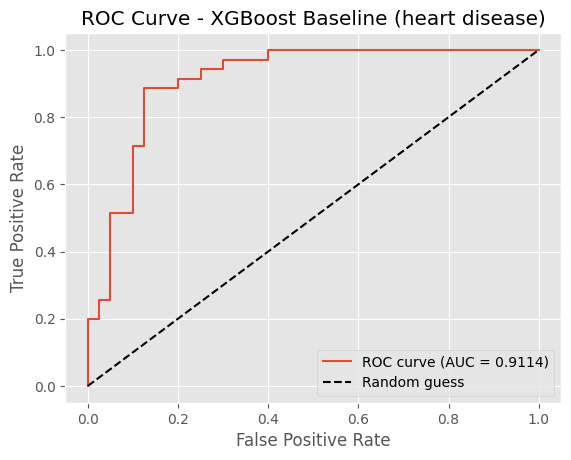

In [40]:
default_xgb = xgb.XGBClassifier(colsample_bytree=0.8, gamma=0.3, max_depth=3, min_child_weight=3, subsample=0.6)
run_test(default_xgb, "XGBoost Baseline (heart disease)", X_trainval, y_trainval, X_test, y_test)

### ENDER Classifier Modified

In [144]:
param_grid = {
    'n_rules': [i for i in range(23, 35)],
    'use_gradient': [True, False],
    'nu': [0.8, 0.85, 0.9, 0.95, 0.99, 1.0],
    'sampling': [0.8, 0.9, 1.0],
    'verbose': [False],
    'random_state': [42]
}

grid_search_m = GridSearchCV(
    estimator=ECM(),
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search_m.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search_m.best_params_)
print("Best cross-val F1:", grid_search_m.best_score_)

best_model = grid_search_m.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

Best hyperparameters: {'n_rules': 29, 'nu': 0.85, 'random_state': 42, 'sampling': 0.8, 'use_gradient': False, 'verbose': False}
Best cross-val F1: 0.8244518127015066

Test set evaluation:
              precision    recall  f1-score   support

           0     0.7955    0.8750    0.8333        40
           1     0.8387    0.7429    0.7879        35

    accuracy                         0.8133        75
   macro avg     0.8171    0.8089    0.8106        75
weighted avg     0.8156    0.8133    0.8121        75

Confusion Matrix:
                    Class 0             Class 1             
Class 0             35                  5                     # True Negative (TN), False Positive (FP)
Class 1             9                   26                    # False Negative (FN), True Positive (TP)


ECM Model (heart disease)
Accuracy: 0.84000
ROC AUC: 0.93000
F1 Score: 0.83333
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.8684    0.8250    0.8462        40
           1     0.8108    0.8571    0.8333        35

    accuracy                         0.8400        75
   macro avg     0.8396    0.8411    0.8397        75
weighted avg     0.8415    0.8400    0.8402        75

Confusion Matrix:
                    Class 0             Class 1             
Class 0             33                  7                     # True Negative (TN), False Positive (FP)
Class 1             5                   30                    # False Negative (FN), True Positive (TP)


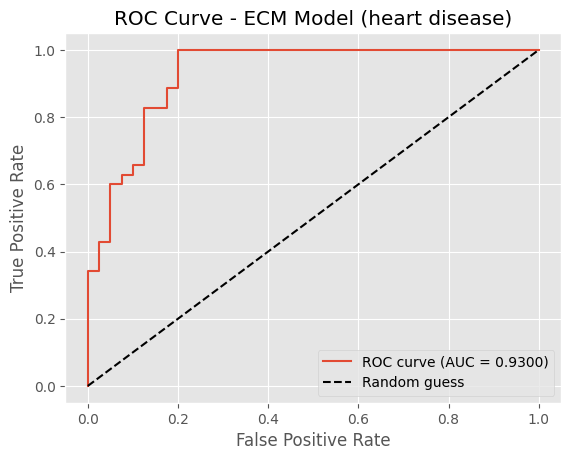

In [42]:
run_test(ECM(n_rules=29, use_gradient=False, nu=0.85, sampling=0.8, verbose=False), "ECM Model (heart disease)", X_trainval, y_trainval, X_test, y_test)

### Bounded ENDER Classifier

In [147]:
param_grid = {
    'n_rules': [i for i in range(20, 35)],
    'use_gradient': [True, False],
    'nu': [0.8, 0.85, 0.9, 0.95, 0.99, 1.0],
    'sampling': [0.8, 0.9, 1.0],
    'verbose': [False],
    'max_clusters': [i for i in range(1, 6)],
    'lambda_reg': [0.0, 0.1, 0.25, 0.5, 0.75, 1.0],
    'random_state': [42]
}

grid_search_bf = GridSearchCV(
    estimator=ECBF(),
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search_bf.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search_bf.best_params_)
print("Best cross-val F1:", grid_search_bf.best_score_)

best_model = grid_search_bf.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

Best hyperparameters: {'lambda_reg': 0.75, 'max_clusters': 4, 'n_rules': 32, 'nu': 0.95, 'random_state': 42, 'sampling': 0.8, 'use_gradient': False, 'verbose': False}
Best cross-val F1: 0.8464343640293727

Test set evaluation:
              precision    recall  f1-score   support

           0     0.8500    0.8500    0.8500        40
           1     0.8286    0.8286    0.8286        35

    accuracy                         0.8400        75
   macro avg     0.8393    0.8393    0.8393        75
weighted avg     0.8400    0.8400    0.8400        75

Confusion Matrix:
                    Class 0             Class 1             
Class 0             34                  6                     # True Negative (TN), False Positive (FP)
Class 1             6                   29                    # False Negative (FN), True Positive (TP)


ECBF Model (heart disease)
Accuracy: 0.86667
ROC AUC: 0.93786
F1 Score: 0.85714
Classification Report - Test:
              precision    recall  f1-score   support

           0     0.8750    0.8750    0.8750        40
           1     0.8571    0.8571    0.8571        35

    accuracy                         0.8667        75
   macro avg     0.8661    0.8661    0.8661        75
weighted avg     0.8667    0.8667    0.8667        75

Confusion Matrix:
                    Class 0             Class 1             
Class 0             35                  5                     # True Negative (TN), False Positive (FP)
Class 1             5                   30                    # False Negative (FN), True Positive (TP)


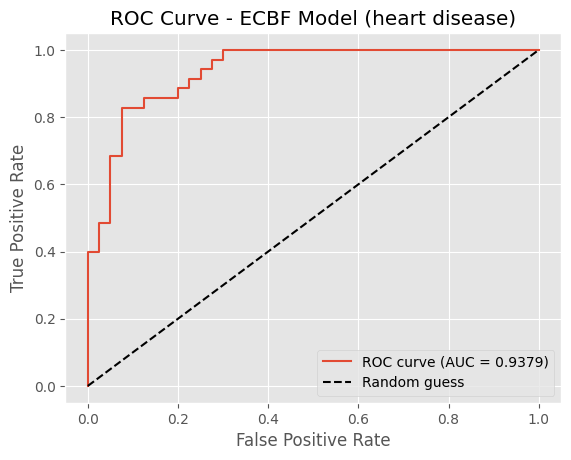

In [43]:
run_test(ECBF(n_rules=32, use_gradient=False, nu=0.95, sampling=0.8, verbose=False, max_clusters=4, lambda_reg=0.75), "ECBF Model (heart disease)", X_trainval, y_trainval, X_test, y_test)

## Classification on Breast Cancer:

In [44]:
# the target variable is "B" or "M", but we need to convert it to 0 and 1
breast_cancer_y = np.where(breast_cancer_y == 'M', 1.0, 0.0).reshape(-1)
X_trainval, X_test, y_trainval, y_test = train_test_split(breast_cancer_X, breast_cancer_y, test_size=0.25, random_state=42)

### XGBoost baseline

In [187]:
param_grid_xgb = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'base_score': [0.5]
}
grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search_xgb.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search_xgb.best_params_)
print("Best cross-val F1:", grid_search_xgb.best_score_)

best_model = grid_search_xgb.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

Best hyperparameters: {'base_score': 0.5, 'colsample_bytree': 0.6, 'gamma': 0.3, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.8}
Best cross-val F1: 0.9616576479076479

Test set evaluation:
              precision    recall  f1-score   support

         0.0     0.9773    0.9663    0.9718        89
         1.0     0.9455    0.9630    0.9541        54

    accuracy                         0.9650       143
   macro avg     0.9614    0.9646    0.9629       143
weighted avg     0.9653    0.9650    0.9651       143

Confusion Matrix:
                    Class 0             Class 1             
Class 0             86                  3                     # True Negative (TN), False Positive (FP)
Class 1             2                   52                    # False Negative (FN), True Positive (TP)


XGBoost Baseline (breast cancer)
Accuracy: 0.96503
ROC AUC: 0.99168
F1 Score: 0.95413
Classification Report - Test:
              precision    recall  f1-score   support

         0.0     0.9773    0.9663    0.9718        89
         1.0     0.9455    0.9630    0.9541        54

    accuracy                         0.9650       143
   macro avg     0.9614    0.9646    0.9629       143
weighted avg     0.9653    0.9650    0.9651       143

Confusion Matrix:
                    Class 0             Class 1             
Class 0             86                  3                     # True Negative (TN), False Positive (FP)
Class 1             2                   52                    # False Negative (FN), True Positive (TP)


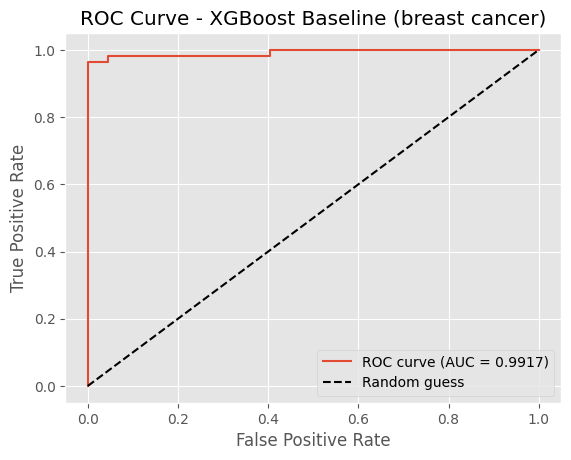

In [45]:
xgb_model = xgb.XGBClassifier(colsample_bytree=0.6, gamma=0.3, max_depth=4, min_child_weight=3, subsample=0.8)
run_test(xgb_model, "XGBoost Baseline (breast cancer)", X_trainval, y_trainval, X_test, y_test)

### ENDER Classifier Modified

In [189]:
param_grid = {
    'n_rules': [i for i in range(14, 30)],
    'use_gradient': [True, False],
    'nu': [0.8, 0.85, 0.9, 0.95, 0.99, 1.0],
    'sampling': [0.8, 0.9, 1.0],
    'verbose': [False],
    'random_state': [42]
}

grid_search_m = GridSearchCV(
    estimator=ECM(),
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search_m.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search_m.best_params_)
print("Best cross-val F1:", grid_search_m.best_score_)

best_model = grid_search_m.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

Best hyperparameters: {'n_rules': 17, 'nu': 0.85, 'random_state': 42, 'sampling': 0.9, 'use_gradient': True, 'verbose': False}
Best cross-val F1: 0.961857448107448

Test set evaluation:
              precision    recall  f1-score   support

         0.0     0.9770    0.9551    0.9659        89
         1.0     0.9286    0.9630    0.9455        54

    accuracy                         0.9580       143
   macro avg     0.9528    0.9590    0.9557       143
weighted avg     0.9587    0.9580    0.9582       143

Confusion Matrix:
                    Class 0             Class 1             
Class 0             85                  4                     # True Negative (TN), False Positive (FP)
Class 1             2                   52                    # False Negative (FN), True Positive (TP)


ECM Model (breast cancer)
Accuracy: 0.95804
ROC AUC: 0.99334
F1 Score: 0.94545
Classification Report - Test:
              precision    recall  f1-score   support

         0.0     0.9770    0.9551    0.9659        89
         1.0     0.9286    0.9630    0.9455        54

    accuracy                         0.9580       143
   macro avg     0.9528    0.9590    0.9557       143
weighted avg     0.9587    0.9580    0.9582       143

Confusion Matrix:
                    Class 0             Class 1             
Class 0             85                  4                     # True Negative (TN), False Positive (FP)
Class 1             2                   52                    # False Negative (FN), True Positive (TP)


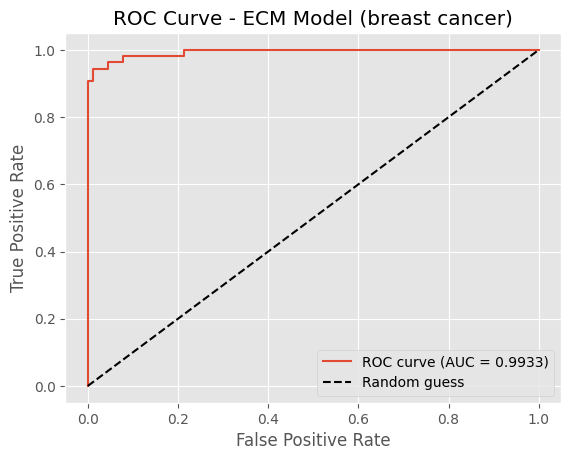

In [47]:
run_test(ECM(n_rules=17, use_gradient=True, nu=0.85, sampling=0.9, verbose=False), "ECM Model (breast cancer)", X_trainval, y_trainval, X_test, y_test)

### Bounded ENDER Classifier

In [197]:
param_grid = {
    'n_rules': [i for i in range(24, 37)],
    'use_gradient': [True, False],
    'nu': [0.8, 0.9, 0.95, 0.99, 1.0],
    'sampling': [0.8, 0.9, 1.0],
    'verbose': [False],
    'max_clusters': [i for i in range(1, 6)],
    'lambda_reg': [0.0, 0.1, 0.25, 0.5],
    'random_state': [42]
}

grid_search_bf = GridSearchCV(
    estimator=ECBF(),
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search_bf.fit(X_trainval, y_trainval)
print("Best hyperparameters:", grid_search_bf.best_params_)
print("Best cross-val F1:", grid_search_bf.best_score_)

best_model = grid_search_bf.best_estimator_
best_model.fit(X_trainval, y_trainval)

y_pred = best_model.predict(X_test)
print("\nTest set evaluation:")
print(classification_report(y_test, y_pred, digits=4))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Class 0', 'Class 1']
print("Confusion Matrix:")
print(f"{'':<20}{labels[0]:<20}{labels[1]:<20}")
print(f"{labels[0]:<20}{cm[0, 0]:<20}{cm[0, 1]:<20}  # True Negative (TN), False Positive (FP)")
print(f"{labels[1]:<20}{cm[1, 0]:<20}{cm[1, 1]:<20}  # False Negative (FN), True Positive (TP)")

Best hyperparameters: {'lambda_reg': 0.0, 'max_clusters': 3, 'n_rules': 30, 'nu': 0.99, 'random_state': 42, 'sampling': 0.8, 'use_gradient': True, 'verbose': False}
Best cross-val F1: 0.9741885119991942

Test set evaluation:
              precision    recall  f1-score   support

         0.0     0.9778    0.9888    0.9832        89
         1.0     0.9811    0.9630    0.9720        54

    accuracy                         0.9790       143
   macro avg     0.9795    0.9759    0.9776       143
weighted avg     0.9790    0.9790    0.9790       143

Confusion Matrix:
                    Class 0             Class 1             
Class 0             88                  1                     # True Negative (TN), False Positive (FP)
Class 1             2                   52                    # False Negative (FN), True Positive (TP)


ECBF Model (breast cancer)
Accuracy: 0.97203
ROC AUC: 0.99688
F1 Score: 0.96364
Classification Report - Test:
              precision    recall  f1-score   support

         0.0     0.9885    0.9663    0.9773        89
         1.0     0.9464    0.9815    0.9636        54

    accuracy                         0.9720       143
   macro avg     0.9675    0.9739    0.9705       143
weighted avg     0.9726    0.9720    0.9721       143

Confusion Matrix:
                    Class 0             Class 1             
Class 0             86                  3                     # True Negative (TN), False Positive (FP)
Class 1             1                   53                    # False Negative (FN), True Positive (TP)


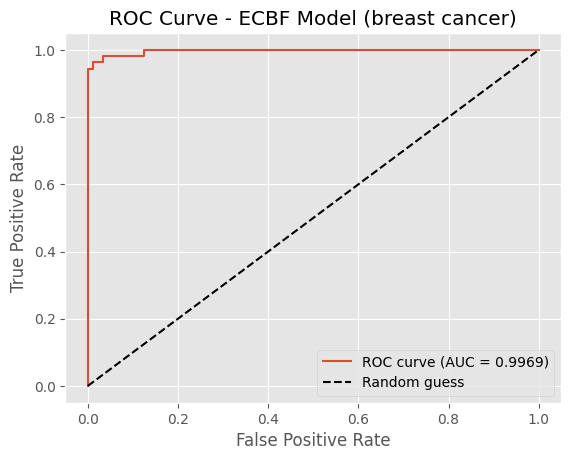

In [48]:
run_test(ECBF(n_rules=30, use_gradient=True, nu=0.99, sampling=0.8, verbose=False, max_clusters=3, lambda_reg=0.0), "ECBF Model (breast cancer)", X_trainval, y_trainval, X_test, y_test)